In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn,optim
import numpy as np
import sys
sys.path.append('../code/')
import d2l_2 as d2l
from PIL import Image
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
conv=nn.Conv2d(3,10,kernel_size=4,padding=1,stride=2)
X=torch.randn((1,3,64,64))
Y=conv(X)
Y.shape

torch.Size([1, 10, 32, 32])

In [3]:
conv_trans=nn.ConvTranspose2d(10,3,kernel_size=4,padding=1,stride=2)
conv_trans(Y).shape

torch.Size([1, 3, 64, 64])

In [4]:
pretrained_net=torchvision.models.resnet18(pretrained=True)

In [5]:
num_classes=21
net=nn.Sequential()
net.add_module('conv1',pretrained_net.conv1)
net.add_module('bn1',pretrained_net.bn1)
net.add_module('relu',pretrained_net.relu)
net.add_module('maxpool',pretrained_net.maxpool)
net.add_module('layer1',pretrained_net.layer1)
net.add_module('layer2',pretrained_net.layer2)
net.add_module('layer3',pretrained_net.layer3)
net.add_module('layer4_0)',pretrained_net.layer4[0])
net.add_module('layer4_1)',pretrained_net.layer4[1].conv1)
net.add_module('layer4_2)',pretrained_net.layer4[1].bn1)
net.add_module('layer4_3)',pretrained_net.layer4[1].relu)
net.add_module('layer4_4)',pretrained_net.layer4[1].conv2)
net.add_module('Conv2d',nn.Conv2d(512,num_classes,kernel_size=1))
net.add_module('ConvTranspose2d',nn.ConvTranspose2d(num_classes,num_classes,kernel_size=64,padding=16,stride=32))

In [6]:

net

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [7]:
conv_trans=nn.ConvTranspose2d(3,3,4,2,1)
img=Image.open('../docs/img/catdog.jpg')
X=torchvision.transforms.ToTensor()(img).unsqueeze(dim=0)/255
print(X.shape)
Y=conv_trans(X)
print(Y.shape)

torch.Size([1, 3, 561, 728])
torch.Size([1, 3, 1122, 1456])


In [8]:
crop_size,batch_size,colormap2label=(320,480),8,torch.zeros(256**3)
for i,cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0]*256+cm[1])*256+cm[2]]=i
voc_dir='../data/VOCdevkit/VOC2012'
train_iter=torch.utils.data.DataLoader(d2l.VOCSegDataset(True,crop_size,voc_dir,colormap2label),batch_size,
                                      shuffle=True,drop_last=True)
test_iter=torch.utils.data.DataLoader(d2l.VOCSegDataset(False,crop_size,voc_dir,colormap2label),batch_size,
                                      drop_last=True)

1464it [00:06, 233.33it/s]
28it [00:00, 273.40it/s]

read 1114 valid examples


1449it [00:06, 232.98it/s]

read 1078 valid examples


In [9]:
for X,y in train_iter:
    print(X.shape)
    print(net.to(device)(X.to(device)).shape)
    print(y.shape)
    break

torch.Size([8, 3, 320, 480])
torch.Size([8, 21, 320, 480])
torch.Size([8, 320, 480])


In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss=nn.CrossEntropyLoss()
net=net.to(device)
optimizer=optim.SGD(net.parameters(),lr=0.01,weight_decay=0.2)
d2l.train(train_iter,test_iter,net,loss,optimizer,device,num_epochs=20)

training on  cuda


KeyboardInterrupt: 

In [12]:
def predict(img):
    X=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=np.array([0.485,0.456,0.406]),std=np.array([0.229,0.224,0.225]))
        ])(img)
    X=X.unsqueeze(dim=0)
    print(X.shape)
    pred=torch.argmax(net.to(device)(X.to(device)),dim=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    colormap =torch.tensor(d2l.VOC_COLORMAP)
    X=pred.to(torch.device('cpu')).numpy().astype('int32')
    return colormap[X,:]

1449it [00:05, 263.73it/s]


torch.Size([1, 3, 320, 480])
torch.Size([1, 3, 320, 480])
torch.Size([1, 3, 320, 480])
torch.Size([1, 3, 320, 480])


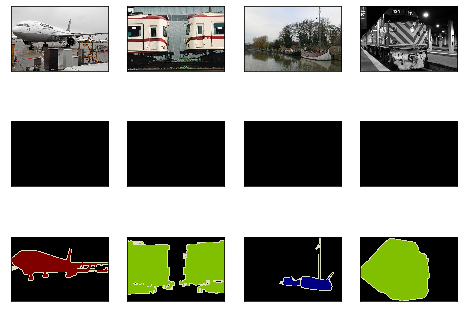

In [13]:
test_images, test_labels = d2l.read_voc_images(root='../data/VOCdevkit/VOC2012',is_train=False)
n,imgs=4,[]
#d2l.show_images(test_images[0:5]+test_labels[0:5],2,5);
for i in range(n):
    #d2l.show_images(test_images[i],1,1)
    X,pred_label=d2l.voc_rand_crop(test_images[i],test_labels[i],320,480)
    pred=label2image(predict(X))
    imgs += [X, pred,pred_label]
    
d2l.show_images(imgs[::3]+imgs[1::3]+ imgs[2::3],3,n);